In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Updating registry at `/opt/julia/share/site/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %                                  ]  12.7 % %]  49.4 % [===========================>             ]  66.8 %      ]  84.8 %

In [2]:
using Revise
using Plots
pyplot()
using Distributions
using StatisticalProcesses

┌ Info: Recompiling stale cache file /opt/julia/share/site/compiled/v1.1/StatisticalProcesses/LdB7Q.ji for StatisticalProcesses [02341bee-6029-11e9-3dea-e3893ab4fa4b]
└ @ Base loading.jl:1184


In [210]:
using LinearAlgebra: norm

k(x, xp; σ, δ) = δ^2 * exp(-norm(x-xp)^2/(2σ^2))
lj(x) = 1 ./ x.^12  - 1 ./ x.^6

lj (generic function with 1 method)

StatisticalProcesses.loglikelihood(gp) = 27.142867974098692
variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.1, 1.0, 0.5]
lower = [0.001, 0.001, 0.001]
upper = [Inf, Inf, Inf]
Initial: Dict(:σn=>0.1,:σ=>1.0,:δ=>0.5)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.1,1.0,0.5]
 * Minimizer: [0.013087512755183902,0.1174980831287798, ...]
 * Minimum: -5.660858e+01
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.93e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 608
 * Gradient Calls: 608
Optimised: Dict(:σn=>0.0130875,:σ=>0.117498,:δ=>0.213493)
loglikelihood(opt_gp) = 56.60857780593062
Marginal likelihood (Laplace approximation): 0.004079697344451287

L1 = StatisticalProcesses.loglikelihood(stp) = 30

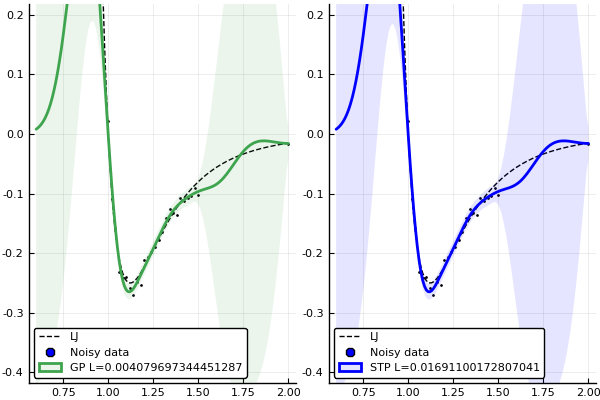

In [415]:
# LJ potential
x = [1.0:0.02:1.5; 2]
yt = lj.(x) 

# Add Student-T distributed noise
t = TDist(2.)
y = yt + 0.01*randn(length(x)) #0.01*rand(t, length(x))

xx = collect(0.6:0.01:2)
yy = 1 ./ xx.^12  - 1 ./ xx.^6

p1 = plot(xx, yy, color=:black, linestyle=:dash, label="LJ", ylims=[-0.4,0.2])
scatter!(x, y, color=:blue, marker=:o, markersize=1, label="Noisy data")

gp = GP(x, y, k; σn=0.1, σ=1.0, δ=0.5)
@show StatisticalProcesses.loglikelihood(gp)

hypers, L_gp, opt_gp = optimize_hypers(gp)
#@show hypers, L_gp

μ, v = opt_gp(xx)
σ = sqrt.(v)

plot!(xx, μ, ribbon=(2σ, 2σ), lw=2, fillalpha=0.1, 
      label="GP L=$(L_gp[3])")
println()

stp = STP(x, y, k; ν=5, σn=0.1, δ=0.5, σ=1.0)
@show L1 = StatisticalProcesses.loglikelihood(stp)

hypers, L_stp, opt_stp = optimize_hypers(stp, fix=[:ν])
#@show hypers, L_stp

#stp_posterior = posterior(stp, xx)

p2 = plot(xx, yy, color=:black, linestyle=:dash, label="LJ")
scatter!(x, y, color=:blue, marker=:o, markersize=1, label="Noisy data")


#opt_stp.hypers[:σn] = 0.15

μ, v = opt_stp(xx)
σ = sqrt.(v)

plot!(xx, μ, lw=2, color=:blue,
      ribbon=(2σ, 2σ), 
      fillalpha=0.1, fillcolor=:blue,
      label="STP L=$(L_stp[3])", ylims=[-0.4,0.2])

plot(p1, p2)

(gp_mae, stp_mae) = (0.009712775020111166, 0.009712775020111166)
(gp_err_err, stp_err_err) = (0.06248076126032172, 0.06469421268668446)


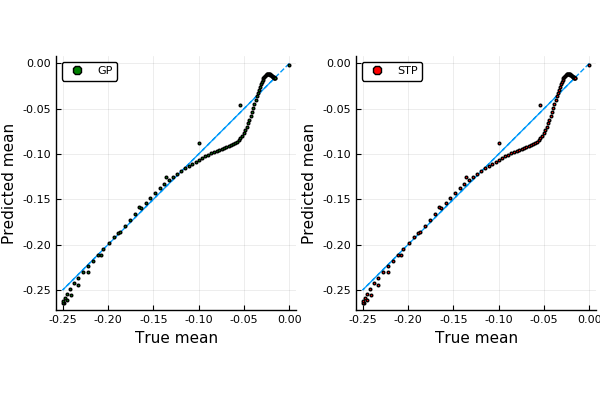

In [416]:
xx = collect(1.0:0.01:2)
yy = 1 ./ xx.^12  - 1 ./ xx.^6

gp_mean, gp_var = predict(opt_gp, xx)
stp_mean, stp_var = predict(opt_stp, xx)

gp_mae = mean(abs.(gp_mean - yy))
stp_mae = mean(abs.(gp_mean - yy))

@show gp_mae, stp_mae

gp_pred_err = sqrt.(gp_var)
gp_err = abs.(gp_mean - yy)

stp_pred_err = sqrt.(stp_var)
stp_err = abs.(stp_mean - yy)

gp_err_err = mean(abs.(gp_err - gp_pred_err))
stp_err_err = mean(abs.(stp_err - stp_pred_err))

@show gp_err_err, stp_err_err

p1 = plot(yy, yy, ls=:dash, label="", xlabel="True mean", ylabel="Predicted mean", aspect_ratio=:equal)
scatter!(yy, gp_mean, marker=:o, ms=2, c=:green, label="GP")

p2 = plot(yy, yy, ls=:dash, label="", xlabel="True mean", ylabel="Predicted mean", aspect_ratio=:equal)
scatter!(yy, stp_mean, marker=:o, ms=2, c=:red, label="STP")

plot(p1, p2)

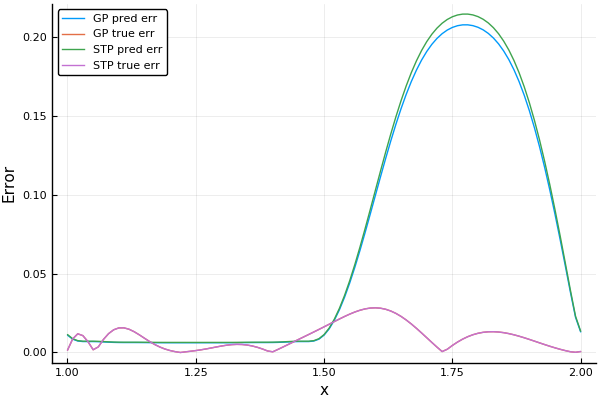

In [417]:
plot(xx, gp_pred_err, label="GP pred err", xlabel="x", ylabel="Error")
plot!(xx, gp_err, label="GP true err")

plot!(xx, stp_pred_err, label="STP pred err")
plot!(xx, stp_err, label="STP true err")

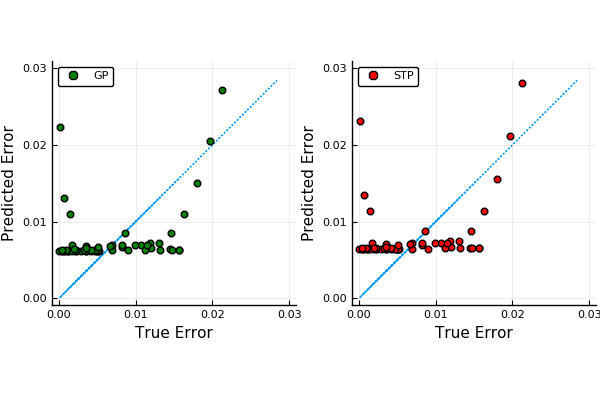

In [418]:
p1 = plot(gp_err, gp_err, ls=:dot, label="", xlims=[0,0.03], ylims=[0,0.03], aspect_ratio=:equal,
        ylabel="Predicted Error", xlabel="True Error")
scatter!(gp_err, gp_pred_err, marker=:o, ms=5, c=:green, label="GP")

p2 = plot(gp_err, gp_err, ls=:dot, label="", xlims=[0,0.03], ylims=[0,0.03], aspect_ratio=:equal,
        ylabel="Predicted Error", xlabel="True Error")
scatter!(stp_err, stp_pred_err, marker=:o, ms=5, c=:red, label="STP")

plot(p1, p2)

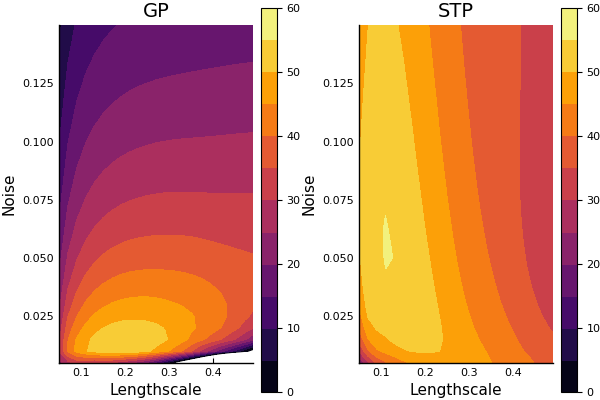

In [419]:
As = 0.05:0.02:0.5
Bs = 0.005:0.005:0.15
L = 0:5:60

gcf(A,B) = loglikelihood(GP(x, y, k, σ=A, σn=B, δ=0.8))
scf(A,B) = loglikelihood(STP(x, y, k, ν=2.1, σ=A, σn=B, δ=0.8))

plot(contourf(As, Bs, gcf, levels=L, clims=(first(L),last(L))), 
     contourf(As, Bs, scf, levels=L, clims=(first(L),last(L))),
     xlabel="Lengthscale", ylabel="Noise", title=["GP" "STP"])

In [420]:
opt_gp.hypers

Dict{Symbol,Float64} with 3 entries:
  :σn => 0.0130875
  :σ  => 0.117498
  :δ  => 0.213493

In [421]:
opt_stp.hypers

Dict{Symbol,Real} with 4 entries:
  :ν  => 5
  :σn => 0.0168959
  :σ  => 0.117498
  :δ  => 0.275618

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.01, 0.1, 0.2]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.01,:σ=>0.1,:δ=>0.2)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.01,0.1,0.2]
 * Minimizer: [0.0602705893357598,0.05584609544813012, ...]
 * Minimum: -3.233666e+00
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 3.39e-11 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.79e-09 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 1509
 * Gradient Calls: 1509
Optimised: Dict(:σn=>0.0602706,:σ=>0.0558461,:δ=>0.0561097)
loglikelihood(opt_gp) = 3.233666089226477
variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.000192712, 0.164905, 0.558064]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:ν=>2.1,:σn=>0.000

Optimised: Dict(:ν=>2.1,:σn=>1.0e-6,:σ=>0.148787,:δ=>0.448037)
loglikelihood(opt_gp) = 8.319510305259634

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [1.0e-6, 0.148787, 0.0977696]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>1.0e-6,:σ=>0.148787,:δ=>0.0977696)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [1.000000274231719e-6,0.14878741794842537, ...]
 * Minimizer: [0.019678553373334216,0.14566694650202408, ...]
 * Minimum: -9.396660e+00
 * Iterations: 1
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.51e-02 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = -3.81e-01 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 3.66e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 88
 * Gradient Calls: 88
Optimised: Dict(:σn=>0.0196786,:σ=>0.145667,:δ=>0.112987)
loglikelihood(opt_gp) = 9.396660047222039
varia


variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.000616878, 0.126643, 0.123008]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.000616878,:σ=>0.126643,:δ=>0.123008)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0006168775919061148,0.1266430340132871, ...]
 * Minimizer: [0.0020858862122290827,0.11443826811360938, ...]
 * Minimum: -2.347388e+01
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.45e-07 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 204
 * Gradient Calls: 204
Optimised: Dict(:σn=>0.00208589,:σ=>0.114438,:δ=>0.145975)
loglikelihood(opt_gp) = 23.473876224700273
variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.00282689, 0.126643, 0.563695]
lower = [1.0e-6, 0.

res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.03428891367760532,0.12887402807804846, ...]
 * Minimizer: [0.0281638808628494,0.13297686953068996, ...]
 * Minimum: -3.203276e+01
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.41e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 150
 * Gradient Calls: 150
Optimised: Dict(:ν=>2.1,:σn=>0.0281639,:σ=>0.132977,:δ=>0.858422)
loglikelihood(opt_gp) = 32.032758519746565

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.00614586, 0.132977, 0.187323]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.00614586,:σ=>0.132977,:δ=>0.187323)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.006

res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.00027331867496489066,0.09693740348633928, ...]
 * Minimizer: [0.0005321039521643058,0.15494867720936353, ...]
 * Minimum: -6.260422e+01
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.70e-03 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 193
 * Gradient Calls: 193
Optimised: Dict(:ν=>2.1,:σn=>0.000532104,:σ=>0.154949,:δ=>5.06055)
loglikelihood(opt_gp) = 62.604219406482876

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.000116114, 0.154949, 1.1043]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.000116114,:σ=>0.154949,:δ=>1.1043)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [

res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0004760897515419822,0.19379930057032943, ...]
 * Minimizer: [0.0004571715521487691,0.19547248629315497, ...]
 * Minimum: -9.597998e+01
 * Iterations: 2
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.95e-01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 60
 * Gradient Calls: 60
Optimised: Dict(:ν=>2.1,:σn=>0.000457172,:σ=>0.195472,:δ=>15.2105)
loglikelihood(opt_gp) = 95.97997920744275

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [9.97522e-5, 0.195474, 3.31888]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>9.97522e-5,:σ=>0.195474,:δ=>3.31888)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [9.97

res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.000602218642004116,0.24862600409583427, ...]
 * Minimizer: [0.0006026850145538311,0.2520303581443697, ...]
 * Minimum: -1.316228e+02
 * Iterations: 2
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 7.07e-03 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 64
 * Gradient Calls: 64
Optimised: Dict(:ν=>2.1,:σn=>0.000602685,:σ=>0.25203,:δ=>42.6512)
loglikelihood(opt_gp) = 131.62276273480725

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.000131511, 0.252034, 9.30734]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.000131511,:σ=>0.252034,:δ=>9.30734)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.00

res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0006296862049223901,0.2538085061935733, ...]
 * Minimizer: [0.0006176255634174955,0.2564641839434399, ...]
 * Minimum: -1.677175e+02
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.10e-02 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 112
 * Gradient Calls: 112
Optimised: Dict(:ν=>2.1,:σn=>0.000617626,:σ=>0.256464,:δ=>46.582)
loglikelihood(opt_gp) = 167.71746159511184

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.00013478, 0.256414, 10.152]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.00013478,:σ=>0.256414,:δ=>10.152)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0001

res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0006163996661260286,0.26074152140780094, ...]
 * Minimizer: [0.0005959107867322389,0.2605835208082185, ...]
 * Minimum: -2.039477e+02
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.34e-01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 71
 * Gradient Calls: 71
Optimised: Dict(:ν=>2.1,:σn=>0.000595911,:σ=>0.260584,:δ=>53.978)
loglikelihood(opt_gp) = 203.9476718702287

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.000131079, 0.261468, 12.1248]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.000131079,:σ=>0.261468,:δ=>12.1248)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.00

res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0005528262812983323,0.26000016654149277, ...]
 * Minimizer: [0.0005484464373013763,0.2579424931320176, ...]
 * Minimum: -2.430646e+02
 * Iterations: 2
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.56e-01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 68
 * Gradient Calls: 68
Optimised: Dict(:ν=>2.1,:σn=>0.000548446,:σ=>0.257942,:δ=>54.6338)
loglikelihood(opt_gp) = 243.06464404972638

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.000119663, 0.257952, 11.9225]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:σn=>0.000119663,:σ=>0.257952,:δ=>11.9225)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.

variable_hypers = Symbol[:σn, :σ, :δ]
initial = [0.000518838, 0.215389, 23.9696]
lower = [1.0e-6, 0.001, 0.001]
upper = [Inf, 0.5, Inf]
Initial: Dict(:ν=>2.1,:σn=>0.000518838,:σ=>0.215389,:δ=>23.9696)
res = Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0005188379158230118,0.21538862281393756, ...]
 * Minimizer: [0.0005103714435354869,0.21480784300324904, ...]
 * Minimum: -2.822767e+02
 * Iterations: 2
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.71e-01 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 54
 * Gradient Calls: 54
Optimised: Dict(:ν=>2.1,:σn=>0.000510371,:σ=>0.214808,:δ=>23.7494)
loglikelihood(opt_gp) = 282.2766969354066



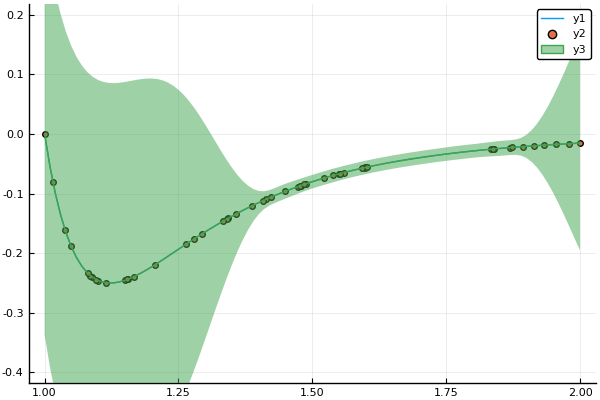

In [411]:
xx = collect(1.0:0.01:2)
yy = lj.(xx)

a = 1.0
b = 2.0
u = Uniform(a, b)
t = Normal() 
#t = TDist(2.)

x = [a, b]
y = lj.(x) + 1e-4*rand(t, 2)

hypers0 = Dict(:σn=>0.01, :σ=>0.1, :δ=>0.2)
stp_hypers0 = copy(hypers)

hypers = copy(hypers0)
stp_hypers = copy(stp_hypers0)

hypers_list = []
stp_hypers_list = []

MAE_gp = []
MPE_gp = []
MAE_opt_gp = []
MPE_opt_gp = []

MAE_stp = []
MPE_stp = []
MAE_opt_stp = []
MPE_opt_stp = []

for i=1:50
    xn = rand(u) # or could be chosen where error is biggest
    x = [x; xn]
    y = [y; lj(xn) + 1e-4*rand(t)]

    gp = GP(x, y, k; hypers0...)
    μ, v = predict(gp, xx)
    push!(MAE_gp, mean(abs.(μ-yy)))
    push!(MPE_gp, mean(sqrt.(v)))

    merge!(gp.hypers, hypers) # restart from results of previous optimisation
    hypers, L_gp, opt_gp = optimize_hypers(gp, lower=[1e-6, 1e-3, 1e-3], 
                                           upper=[Inf, 0.5, Inf], laplace=false)
    push!(hypers_list, copy(hypers))
    μ, v = predict(opt_gp, xx)
    push!(MAE_opt_gp, mean(abs.(μ-yy)))
    push!(MPE_opt_gp, mean(sqrt.(v)))
    
    stp = STP(x, y, k; ν=2.1, stp_hypers0...)
    μ, v = predict(stp, xx)
    push!(MAE_stp, mean(abs.(μ-yy)))
    push!(MPE_stp, mean(sqrt.(v)))

    merge!(stp.hypers, stp_hypers) # restart from results of previous optimisation
    stp_hypers, L_stp, opt_stp = optimize_hypers(stp, fix=[:ν], lower=[1e-6, 1e-3, 1e-3], 
                                                 upper=[Inf, 0.5, Inf], laplace=false)
    push!(stp_hypers_list, copy(stp_hypers))
    μ, v = predict(opt_stp, xx)
    push!(MAE_opt_stp, mean(abs.(μ-yy)))
    push!(MPE_opt_stp, mean(sqrt.(v)))    
    
    println()
end

p1 = plot(xx, yy, xlim=[1, 2], ylim=[-0.4, 0.2])
scatter!(x, y)
plot!(xx, μ, ribbon=2σ)

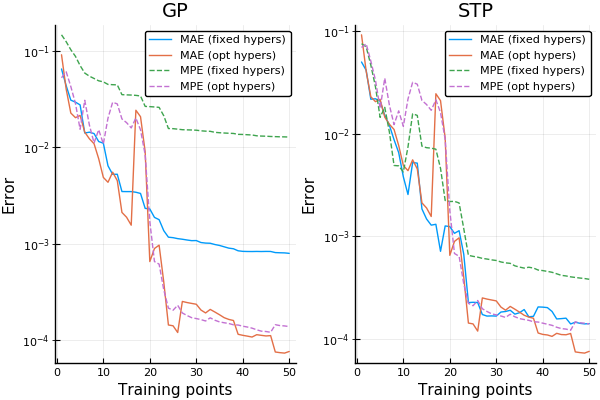

In [412]:
p1 = plot(MAE_gp, label="MAE (fixed hypers)", yscale=:log10, 
          xlabel="Training points", ylabel="Error", title="GP")
plot!(MAE_opt_gp, label="MAE (opt hypers)")
plot!(MPE_gp, label="MPE (fixed hypers)", ls=:dash)
plot!(MPE_opt_gp, label="MPE (opt hypers)", ls=:dash)

p2 = plot(MAE_stp, label="MAE (fixed hypers)", yscale=:log10, 
          xlabel="Training points", ylabel="Error", title="STP")
plot!(MAE_opt_stp, label="MAE (opt hypers)")
plot!(MPE_stp, label="MPE (fixed hypers)", ls=:dash)
plot!(MPE_opt_stp, label="MPE (opt hypers)", ls=:dash)

p3 = plot([h[:σn] for h in hypers_list], label="Noise", yscale=:log10, title="GP hypers")
plot!([h[:σ] for h in hypers_list], label="Lengthscale")
plot!([h[:δ] for h in hypers_list], label="Delta")

p4 = plot([h[:σn] for h in stp_hypers_list], label="Noise", yscale=:log10, title="STP hypers")
plot!([h[:σ] for h in stp_hypers_list], label="Lengthscale")
plot!([h[:δ] for h in stp_hypers_list], label="Delta")

plot(p1, p2)

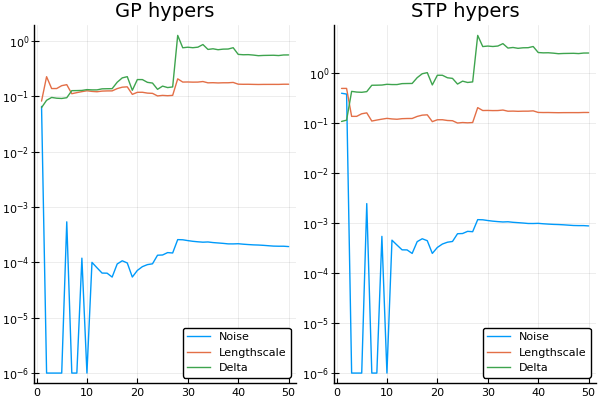

In [408]:
plot(p3, p4)